In [199]:
import word2vec as w2v
import gensim
import os
import csv
import nltk
import numpy as np

from scipy.spatial.distance import cosine as cosine_distance

In [101]:
porter = nltk.PorterStemmer()

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

stopw = set(stopwords.words('english'))
stopw.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])

def remove_stopw(s):
    s = clean_phrase(s)
    s = ' '.join([i for i in wordpunct_tokenize(s) if i not in stopw])
    return s

def clean_token(w):
    w = porter.stem(''.join([a.lower() for a in w if a.isalnum()]))
    return w
    
def clean_phrase(s):
    s = s.split()
    s = ' '.join([clean_token(w) for w in s])
    return s

clean_phrase("Testing how\nthis thing splits\twhitespace")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rafael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


u'test how thi thing split whitespac'

In [2]:
# concat court cases to train word2vec
casepath = 'CourtCases'

In [73]:
# Build clean file for Word2Vec training
fns = [fn for fn in os.listdir(casepath) if fn[0] != '.']
with open('clean_cases.txt', 'w') as catfile:
    for i, fn in enumerate(fns):
        with open(os.path.join(casepath, fn)) as infile:
            s = clean_phrase(infile.read())+'\n'
            catfile.write(s)
        if i % 1000 == 0:
            print "Read %d files" % i

Read 0 files
Read 1000 files
Read 2000 files
Read 3000 files
Read 4000 files
Read 5000 files
Read 6000 files
Read 7000 files
Read 8000 files
Read 9000 files
Read 10000 files
Read 11000 files
Read 12000 files
Read 13000 files
Read 14000 files
Read 15000 files
Read 16000 files
Read 17000 files
Read 18000 files
Read 19000 files
Read 20000 files
Read 21000 files
Read 22000 files
Read 23000 files
Read 24000 files
Read 25000 files
Read 26000 files
Read 27000 files
Read 28000 files
Read 29000 files
Read 30000 files
Read 31000 files
Read 32000 files
Read 33000 files
Read 34000 files
Read 35000 files
Read 36000 files
Read 37000 files
Read 38000 files
Read 39000 files
Read 40000 files
Read 41000 files
Read 42000 files
Read 43000 files
Read 44000 files
Read 45000 files
Read 46000 files
Read 47000 files
Read 48000 files
Read 49000 files
Read 50000 files
Read 51000 files
Read 52000 files
Read 53000 files
Read 54000 files
Read 55000 files
Read 56000 files
Read 57000 files
Read 58000 files
Read 59000

In [3]:
#model = w2v.word2vec('clean_cases.txt', 'cases_w2v.bin', size=150, window=15)
model = gensim.models.Word2Vec.load_word2vec_format('cases_w2v.bin', binary=True)
# model = gensim.models.Word2Vec.load_word2vec_format('cases.bin', binary=True, unicode_errors='ignore')
# Forgot to clean text. This should improve performance.
# Edit: Cleaned for alphanum and lemmatized.

In [15]:
model.most_similar(positive=clean_token('lease'), negative=clean_token('debtor'))

[(u'nineteenthcenturi', 0.4749404788017273),
 (u'longheld', 0.4300786852836609),
 (u'congress', 0.4180983304977417),
 (u'9congress', 0.40613919496536255),
 (u'edmich1997', 0.39734798669815063),
 (u'where', 0.38584786653518677),
 (u'illctcl', 0.3815145492553711),
 (u'1946', 0.3814910650253296),
 (u'it', 0.38054129481315613),
 (u'underlay', 0.37926971912384033)]

In [16]:
with open('inputData.csv', 'r') as infile:
    reader = csv.reader(infile)
    data = [row for row in reader]

with open('outputData.csv', 'r') as testfile:
    reader = csv.reader(testfile)
    test = [row for row in reader]

questions = [d[0] for d in data]
answers = [d[1:] for d in data]

validation = [t[1] for t in test]

In [228]:
# Similarity between sentences

def similarity_topn(q, a, n=300):
    scores = []
    # Get inner product
    # score = sum([w*q for (w,q) in zip(wq,wa)])
    # q = clean_phrase(q)
    # a = clean_phrase(a)
    for wq in q.split():
        for wa in a.split():
            try: # Shouldn't happen anymore
                scores.append(model.similarity(wq, wa))
            except: # Shouldn't happen anymore
                pass
    num = min(n, len(scores))
    scores = sorted(scores)[-num:]
    scores = [s for s in scores if s < .999]
    score = sum(scores)
    return scores

def similarity_topn_words(q, a, mins, maxs):
    # Get inner product
    # score = sum([w*q for (w,q) in zip(wq,wa)])
    # q = clean_phrase(q)
    # a = clean_phrase(a)
    words = []
    for wq in q.split():
        for wa in a.split():
            try: # Shouldn't happen anymore
                score = model.similarity(wq, wa)
                if score >= mins and score <= maxs:
                    words.append((wq,wa))
            except: # Shouldn't happen anymore
                pass
    return words

def similarity(q, a):
    score = 0.0
    no_count = 0
    # Get inner product
    # score = sum([w*q for (w,q) in zip(wq,wa)])

    for wq in q.split():
        for wa in a.split():
            try: # Shouldn't happen anymore
                score += model.similarity(wq, wa)
            except: # Shouldn't happen anymore
                no_count += 1
    score /= ((len(q)*len(a)) - no_count)
    return score

def similarity_log(q, a):
    # >50% benchmark
    no_count = 0
    words = {}
    for wq in q.split():
        for wa in a.split():
            try:
                key = wq+wa
                words[key] = words.setdefault(key, 0) + model.similarity(wq, wa)
            except:
                no_count += 1
    scores = words.values()
    scores_pos = [np.log(k+1) for k in words.values() if k > 0]
    scores_neg = [np.log(-k+1) for k in words.values() if k < 0]
    score = (sum(scores_pos)-sum(scores_neg))/((len(q)*len(a)) - no_count)
    # return sorted([-s for s in scores_neg]+scores_pos)
    return score

def sum_embeddings(q, a):
    # Cosine distance of sum of embeddings
    # 16% benchmark
    q = q.split()
    a = a.split()
    sq = np.array([0.0]*150)
    sa = np.array([0.0]*150)
    for qw in q:
        try:
            sq += model[qw]
        except:
            pass
    for aw in a:
        try:
            sa += model[aw]
        except:
            pass
    sq /= len(qw)
    sa /= len(aw)
    return cosine_distance(sq,sa)  

def rank_answers(q, alist, n=300):
    q = remove_stopw(q)
    simlist = []
    for a in alist:
        a = remove_stopw(a)
        simlist.append(similarity_log(q, a))
    #return [a for (a, s) in sorted(zip(alist, simlist))]
    return alist[simlist.index(max(simlist))]

def rank_answers_cos(q, alist):
    # Minimize cosine distance between embeddings
    q = remove_stopw(q)
    simlist = []
    for a in alist:
        a = remove_stopw(a)
        simlist.append(sum_embeddings(q, a))
    return alist[simlist.index(max(simlist))]

In [230]:
top_answer = [rank_answers(q,a) for q,a in zip(questions,answers)]
correct = [int(i == j) for (i,j) in zip(top_answer, validation)]
(sum(correct)*1.0)/len(validation)

0.47

In [66]:
from matplotlib import pyplot as plt
%matplotlib inline

[60.897689261941039,
 109.40577556350532,
 38.389167050326435,
 86.125797473845367,
 237.30708703225395]

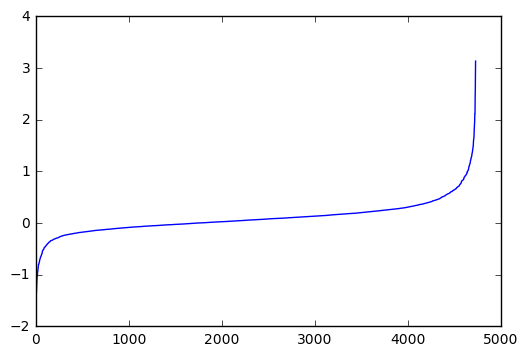

In [188]:
row = 50
qa = (questions[row], answers[row])
q = remove_stopw(qa[0])
a = remove_stopw(qa[1][4])

sim = similarity_log(q, a)
plt.plot(sim)

[sum(similarity_log(q, aa))/len(qa) for aa in qa[1]]
#[sum(similarity_log(q, aa)) for aa in qa[1]]

In [127]:
similarity_topn_words(q, a, .65, .70)

[(u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfere', u'transfer'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'transfer', u'transfere'),
 (u'truste', u'debtor'),
 (u'truste', u'debtor'),
 (u'truste', u'debtor'),
 (u'truste', u'debtor'),
 (u'truste', u'debtor'),
 (u'proceed', u'action'),
 (u'proceed', u'case'),
 (u'proceed', u'case'),
 (u'proceed', u'case'),
 (u'proceed', u'case'),
 (u'proceed', u'case'),
 (u'proceed', u'case'),
 (u'transfer', 

In [88]:
questions[50]

'Can subsequent transferees, who were not named in a judgment avoiding an initial transfer, require the trustee in a subsequent recovery proceeding to re-establish the avoidability of the transfer?'

In [91]:
qa[1][1]

'It is these subsequent transferees of Fairfield and Kingate who have raised the issues related to the interpretation of section 550(a) now before this Court. Specifically, the defendants have moved to dismiss the Trustee\'s complaints in their respective adversary proceedings, arguing that the Trustee has failed to avoid the relevant transfers from Madoff Securities, thereby precluding recovery from them under section 550(a). See 11 U.S.C. \xc2\xa7 550(a) (permitting recovery of transfers " to the extent that a transfer is avoided" under one of the Bankruptcy Code\'s avoidance provisions). The defendants here also moved to withdraw the reference to the Bankruptcy Court, which the Court granted with respect to the following issues: " (1) whether, as a precondition for pursuing a recovery action against a subsequent transferee under 11 U.S.C. \xc2\xa7 550(a), the Trustee must first obtain a fully litigated, final judgment of avoidance against the relevant initial transferee under 11 U.S